In [7]:
from pymagdisc.bfield.magneticField3D import mdiscMagneticField3D, dipoleMagneticField3D, MDiscField, _calc_posn
from pymagdisc.vis.plot_compare_mdisc_dipole import plot_compare_mdisc_dipole
from pymagdisc.vis.plot_compare_contours_alpha import plot_compare_contours_alpha
from pymagdisc.data.load_data import load_model
from pymagdisc import config
from scipy.interpolate import RectBivariateSpline as interp2
import numpy as np
import matplotlib.pyplot as plt

# Compare mdisc vs dipole magnetic potential (from MDisc data file)

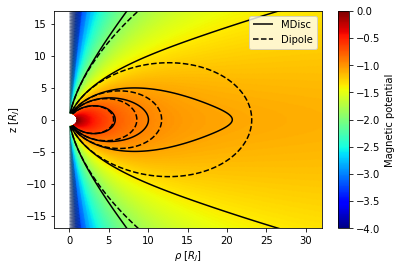

In [8]:
plot_compare_contours_alpha(radDist=1, colatDeg = [6, 12, 17, 20, 25], MDFile='jup_mdisc_kh3e7_rmp90fix.mat')

# Plot Jupiter's magnetodisc vs dipole vector field

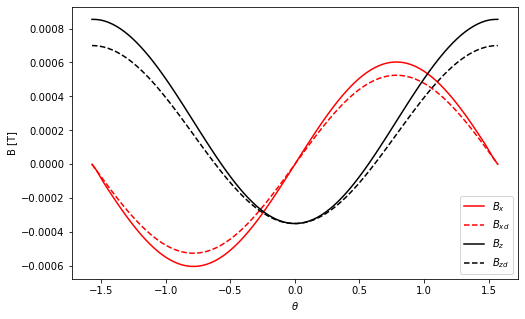

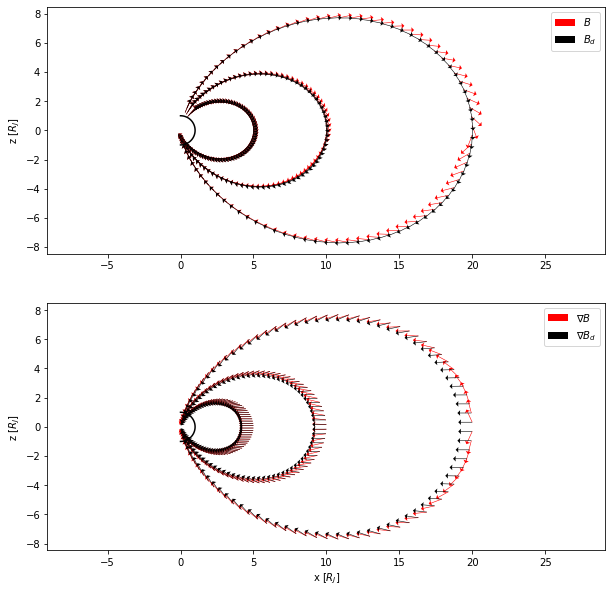

In [9]:
plot_compare_mdisc_dipole(MDFile='jup_mdisc_kh3e7_rmp90fix.mat')

For the magnetodisc field lines (red), they are more squashed than the dipole field lines, so the vector arrows are pointing almost in the same direction for a large part of the field line from the north footpoint and only changes direction very rapidly when it crosses the equator, and then again the arrows are pointing almost in the same direction on the way back. 
For dipole field lines (black), the curve is more gradual so the vector arrows can almost follow the field line itself.

# MDiscField

In [10]:
MDFile = 'jup_mdisc_kh3e7_rmp90fix.mat'
MD = load_model(f'{config.PATH_TO_DATA}{MDFile}');

# equatorial radius in m
Re = MD['planet']['r0']

# magnetic equator field strength in T
B0 = MD['planet']['B0']

# corrected to match dipole value in the magnetodisc file
B0 = MD['planet']['B0'] * MD['v2d']['Bthdip'][MD['dims']['imu0']-1, 0]
Md = [0,0,B0*Re**3]  # Magnetic moment (z-aligned)
Rd = [0,0,0]    # Centered moment (no offset)

p = 0
t = np.linspace(-np.pi/2, np.pi/2, 100)

# unit half circle
x = np.cos(t)*np.cos(p)
y = np.cos(t)*np.sin(p)
z = np.sin(t)

X, Y, Z = x, y, z

# R modulus
R = np.sqrt(X**2 + Y**2 + Z**2)

# Projection on (x,y) plane
Rcyl = np.sqrt(X**2 + Y**2)

# colatitude in radians
theta = np.pi/2 - np.arctan2(Z, Rcyl)

In [11]:
MD['c2d']['r'].shape, MD['c2d']['mu'].shape, MD['c2d']['r'][0,:].shape, MD['c2d']['mu'][:,0].shape, MD['v2d']['Br'].T.shape

((501, 400), (501, 400), (400,), (501,), (400, 501))

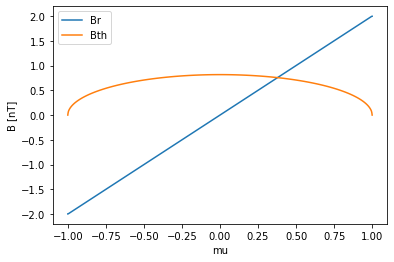

In [12]:
# Define mu = cos(theta)
mu = np.cos(theta)
Br = interp2(MD['c2d']['r'][0,:], MD['c2d']['mu'][:,0], MD['v2d']['Br'].T).ev(R, mu)
Bth = interp2(MD['c2d']['r'][0,:], MD['c2d']['mu'][:,0], MD['v2d']['Bth'].T).ev(R, mu)
plt.plot(mu, Br, label='Br')
plt.plot(mu, Bth, label='Bth')
plt.xlabel('mu')
plt.ylabel('B [nT]')
plt.legend()


Text(0, 0.5, 'dB/dr [T/m]')

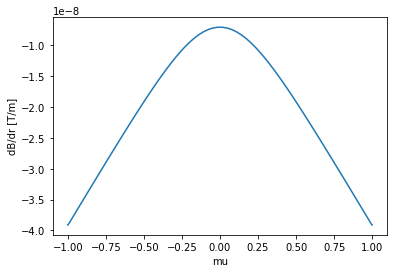

In [13]:
EPS=1e-6
dr = 2*R*EPS * MD['scales']['length']
rp = R*(1+EPS)
rm = R*(1-EPS)
dBdr = (interp2(MD['c2d']['r'][0,:], MD['c2d']['mu'][:,0], MD['v2d']['B'].T).ev(rp, mu) - \
        interp2(MD['c2d']['r'][0,:], MD['c2d']['mu'][:,0], MD['v2d']['B'].T).ev(rm, mu) \
        ) / dr
plt.plot(mu, dBdr)
plt.xlabel('mu')
plt.ylabel('dB/dr [T/m]')

Text(0, 0.5, '$dB/d\\theta$ [T/m]')

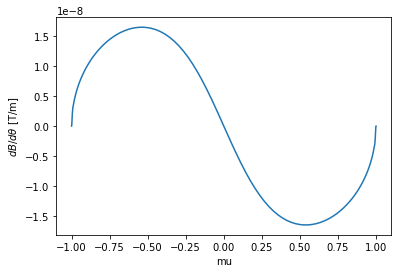

In [14]:
# tangential component
dmudt = -np.sqrt(1-mu**2)

# add EPS to deal with mu=0
mup = mu*(1+EPS)+EPS
mum = mu*(1-EPS)-EPS
rdmu = R*(mup-mum) * MD['scales']['length']
dBdt = (interp2(MD['c2d']['r'][0,:], MD['c2d']['mu'][:,0], MD['v2d']['B'].T).ev(R, mup) - \
        interp2(MD['c2d']['r'][0,:], MD['c2d']['mu'][:,0], MD['v2d']['B'].T).ev(R, mum) \
        ) / rdmu * dmudt
plt.plot(mu, dBdt)
plt.xlabel('mu')
plt.ylabel(r'$dB/d\theta$ [T/m]')
